Mass-Spring-Damper Model Estimation
-----------------------------------


### Timing Assessment

Comparison of simulation models.

In [1]:
%reset -f

In [2]:
import numpy as np
import numpy.matlib as ml
from scipy import interpolate, integrate
import time
import timeit

Create the models.

In [3]:
from msd import MSD
from msd.msdc import MSD_CYTHON
from msd.msdu import MSD_PYUBLAS
from msd.msdn import MSD_NUMBA, MSD_NUMBA_JC, msd_integrate
from msd.msdb import MSD_BOOST

In [4]:
# Simulation model
# MODELS = ['python', 'cython', 'pyublas', 'numba', 'boost']
MODELS = ['cython', 'pyublas', 'numba', 'numba_jc', 'boost']
MODELS = ['numba_jc']

# Zero the RNG seed
np.random.seed(1)

# Initial system state and external force input
x0 = np.zeros((2, ))
d0 = 0.0

# Sample period
dt = 0.01

# Start and end time
t0 = 0.0
tN = 15.0

# Create the time vector
T = np.arange(t0, tN, dt)
N = T.shape[0]

# Create the predefined external force vector
T_S0 = np.hstack((t0, np.arange(t0 + 1.0, tN + 1.0, 1.0), tN))
D_S0 = np.hstack((d0, np.array([ d0 + ((_ % 2)*2 - 1) * 1.0 for _ in range(T_S0.shape[0] - 2) ]), d0))
interpfun = interpolate.interp1d(T_S0, D_S0, kind='zero', axis=0, bounds_error=False)
D0 = np.array([ [ interpfun(t) ] for t in T ])
T_S = T_S0.copy()
D_S = D_S0.copy()
D = D0.copy()

In [5]:
M = 100

# Zero the RNG seed
np.random.seed(1)

for model in MODELS:
    # Zero the RNG seed
    np.random.seed(1)

    # Create the simulation model
    if (model == 'python'):
        # Pure Python
        msd = MSD("Mass-Spring-Damper (Python)")
        msd.set_external_forces(T_S, D_S, 'zero')
    elif (model == 'cython'):
        # Cython
        msd = MSD_CYTHON("Mass-Spring-Damper (Cython)")
        msd.set_external_forces(T_S, D_S, 'zero')
    elif (model == 'pyublas'):
        # PyUblas extension
        msd = MSD_PYUBLAS("Mass-Spring-Damper (PyUblas)", N)
        msd.set_external_forces(T_S, D_S, 'zero')
    elif (model == 'numba'):
        # Numba JIT
        msd = MSD_NUMBA("Mass-Spring-Damper (Numba)", N)
        msd.set_external_forces(T_S, D_S, 'zero')
    elif (model == 'numba_jc'):
        # Numba JIT
        msd = MSD_NUMBA_JC(N)
        msd.set_external_forces(T_S, D_S, 0)
    elif (model == 'boost'):
        # Boost extension
        msd = MSD_BOOST("Mass-Spring-Damper (Boost)", N)
        msd.set_external_forces(T_S, D_S, 'zero')

    time_start = timeit.default_timer()
    # Compute the response
    for m in range(M):
        if (model in ['python', 'cython', 'pyublas', 'numba', 'boost']):
            X, Xdot, F = msd.integrate(x0, T)
        elif (model == 'numba_jc'):
            X, Xdot, F = msd_integrate(msd, x0, T)
    time_stop = timeit.default_timer()

    print("Model: {:s}  Time: {:f}".format(model, time_stop - time_start))

    time.sleep(1.0)

Model: numba_jc  Time: 1.824877


<IPython.core.display.Javascript object>


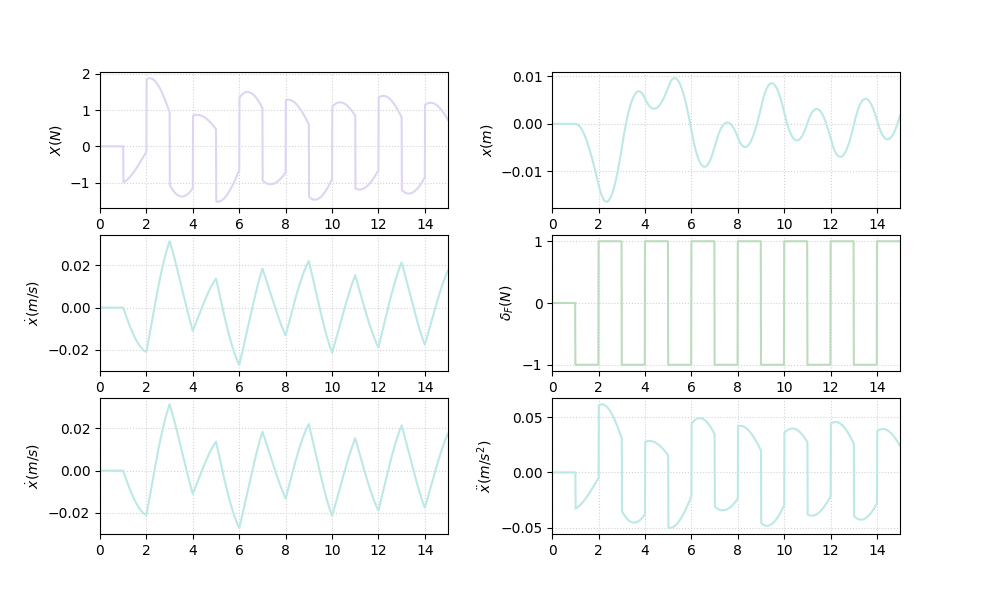

In [6]:
%matplotlib notebook

import matplotlib.pyplot as pp

x_str = [ r'$x (m)$', r'$\dot x (m/s)$' ]
x_fac = [ 1.0, 1.0 ]
xd_str = [ r'$\dot x (m/s)$', r'$\ddot x (m/s^2)$' ]
xd_fac = [ 1.0, 1.0 ]
d_str = [ r'$\delta_F (N)$' ]
d_fac = [ 1.0 ]
f_str = [ r'$X (N)$' ]
f_fac = [ 1.0 ]
ff_str = [ r'ln ${\Delta X}^2 (N^2)$' ]

nc = 2 # number of columns
nr = 3 # number of rows

fig, AxesArr = pp.subplots(nr, nc, figsize=(10.0, 6.0))

Axes = np.ravel(AxesArr)

ax = Axes[0]
ax.grid(color='lightgrey', linestyle=':')
ax.plot(T, F*f_fac[0], color='#DFD4F4', linestyle='-', linewidth=1.5)
ax.set_xlim(T[0], T[N - 1])
ax.autoscale(enable=False)
ax.set_ylabel(f_str[0])

for j in range(2):
    ax = Axes[j + 1]
    ax.grid(color='lightgrey', linestyle=':')
    ax.plot(T, X[:,j]*x_fac[j], color='#BCE8E6', linestyle='-', linewidth=1.5)
    ax.set_xlim(T[0], T[N - 1])
    ax.autoscale(enable=False)
    ax.set_ylabel(x_str[j])

ax = Axes[3]
ax.grid(color='lightgrey', linestyle=':')
ax.plot(T, D*d_fac[0], color='#BDDCBD', linestyle='-', linewidth=1.5)
ax.set_xlim(T[0], T[N - 1])
ax.autoscale(enable=False)
ax.set_ylabel(d_str[0])

for j in range(2):
    ax = Axes[j + 4]
    ax.grid(color='lightgrey', linestyle=':')
    ax.plot(T, Xdot[:,j]*xd_fac[j], color='#BCE8E6', linestyle='-', linewidth=1.5)
    ax.set_xlim(T[0], T[N - 1])
    ax.autoscale(enable=False)
    ax.set_ylabel(xd_str[j])

pp.subplots_adjust(left=0.1, wspace=0.3)